In [1]:
# pip install pyfolio
# pip install nbformat

In [2]:
# Selecting libraries
import nbformat
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings("ignore")

c:\Users\josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


| Variable                  | Description                     |
|---------------------------|---------------------------------|
| Date                     | Date of the data points        |
| PX_LAST                   | Last Price                      |
| PX_BID                    | Bid Price                       |
| LAST_PRICE                | Last Trade/Last Price           |
| PX_ASK                    | Ask Price                       |
| PX_MID                    | Mid Price                       |
| CHG_PCT_1D                | Price Change 1 Day Percent      |
| CUR_MKT_CAP               | Current Market Cap              |
| PX_CLOSE_1D               | Closing Price 1 Day Ago         |

In [3]:
equity = pd.read_csv('./Cleaned_Data/SPX.csv')
highyield = pd.read_csv('./Cleaned_Data/highyield.csv')
safebond = pd.read_csv('./Cleaned_Data/safebond.csv')

equity['Dates'] = pd.to_datetime(equity['Dates'])
highyield['Dates'] = pd.to_datetime(highyield['Dates'])
safebond['Dates'] = pd.to_datetime(safebond['Dates'])

### No Rebalancing - Buy and Hold

Synthetic Portfolio Analysis using index returns

In [4]:
# Define portfolio allocations
allocations_A = {'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50}
allocations_B = {'Equities': 0.40, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.50}
allocations_C = {'Equities': 0.50, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.40}
allocations_D = {'Equities': 0.45, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.45}

# Create a DataFrame using the allocation variables
allocations_df = pd.DataFrame({
    'Asset': ['Equities', 'HighYieldBonds', 'InvGradeBonds'],
    'Index': ['SPX', 'Bloomberg HighYield', 'Bloomberg Agg'],
    'Baseline': [allocations_A['Equities'], allocations_A['HighYieldBonds'], allocations_A['InvGradeBonds']],
    'JS_Strategy': [allocations_B['Equities'], allocations_B['HighYieldBonds'], allocations_B['InvGradeBonds']],
    'JB_Strategy': [allocations_C['Equities'], allocations_C['HighYieldBonds'], allocations_C['InvGradeBonds']],
    'JE_Strategy': [allocations_D['Equities'], allocations_D['HighYieldBonds'], allocations_D['InvGradeBonds']]
})
allocations_df

,Asset,Index,Baseline,JS_Strategy,JB_Strategy,JE_Strategy
0,Equities,SPX,0.5,0.4,0.5,0.45
1,HighYieldBonds,Bloomberg HighYield,0.0,0.1,0.1,0.10
2,InvGradeBonds,Bloomberg Agg,0.5,0.5,0.4,0.45


I think the name for JS: equity is SMALLER; JB: equity is BIGGER; JE: equity and safe bond are EQUAL

In [5]:
start_date = '1983-08-01'
end_date = '2024-06-25'

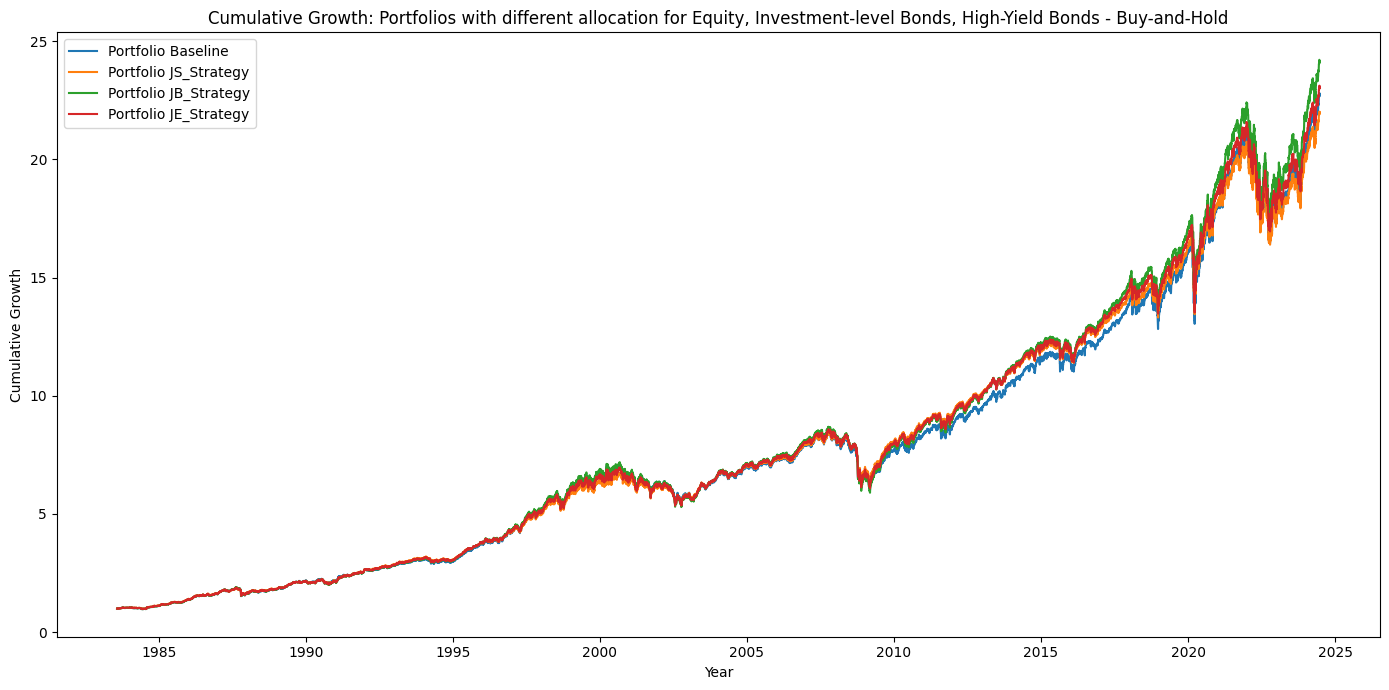

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function with SPY as benchmark for buy-and-hold strategy
def backtest_portfolios_buy_and_hold(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, title =''):
    cumulative_product_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'Index' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Calculate cumulative returns for each asset
        agg_cum_returns = (1 + agg_backtest['DailyReturn']).cumprod()
        jnk_cum_returns = (1 + jnk_backtest['DailyReturn']).cumprod()
        spy_cum_returns = (1 + spy_backtest['DailyReturn']).cumprod()

        # Calculate portfolio cumulative returns based on initial allocation
        portfolio_cumulative_product = (
            allocations['Equities'] * spy_cum_returns +
            allocations['HighYieldBonds'] * jnk_cum_returns +
            allocations['InvGradeBonds'] * agg_cum_returns
        )
        cumulative_product_dict[allocation_name] = portfolio_cumulative_product

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
    #plt.plot(combined_index, (1 + spy_backtest['DailyReturn']).cumprod(), label='SPY (Benchmark)', color='green')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Growth')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cumulative_product_dict

# Call the function and print the results
buy_hold_dict = backtest_portfolios_buy_and_hold(allocations_df, start_date, end_date, 
                                                 title = 'Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds - Buy-and-Hold')

In [7]:
def calculate_performance_metrics(cumulative_product):
    end_return = cumulative_product.iloc[-1] - 1
    daily_returns = cumulative_product.pct_change().dropna()
    annualized_return = np.mean(daily_returns) * 252
    annualized_volatility = np.std(daily_returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    running_max = cumulative_product.cummax()
    drawdown = (cumulative_product - running_max) / running_max
    max_drawdown = drawdown.min()
    max_drawdown_date = drawdown.idxmin().strftime("%Y-%m-%d")
    
    return end_return, annualized_return, annualized_volatility, sharpe_ratio, max_drawdown, max_drawdown_date

In [8]:
# Iterate over each allocation's returns and calculate performance metrics
performance_metrics = {}
for allocation_name, returns in buy_hold_dict.items():
    performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,21.747985,0.055979,0.080388,0.696358,-0.290961,2009-03-09
JS_Strategy,20.97602,0.054374,0.06661,0.816304,-0.258946,2009-03-09
JB_Strategy,23.155385,0.056931,0.079614,0.715088,-0.321133,2009-03-09
JE_Strategy,22.065702,0.055646,0.073057,0.761675,-0.290453,2009-03-09


### Rebalance Daily

In [9]:
# this basically daily rebalancing, fixed allocation

def backtest_portfolios_daily(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, title = ''):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Calculate portfolio daily returns
        portfolio_daily_returns = (
            allocations['Equities'] * spy_backtest['DailyReturn'] +
            allocations['HighYieldBonds'] * jnk_backtest['DailyReturn'] +
            allocations['InvGradeBonds'] * agg_backtest['DailyReturn']
        )

        # Compute cumulative returns
        portfolio_cumulative_product = (1 + portfolio_daily_returns).cumprod()
        cumulative_product_dict[allocation_name] = portfolio_cumulative_product
        
        portfolio_daily_returns_dict[allocation_name] = portfolio_daily_returns
        

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cumulative_product_dict, portfolio_daily_returns_dict

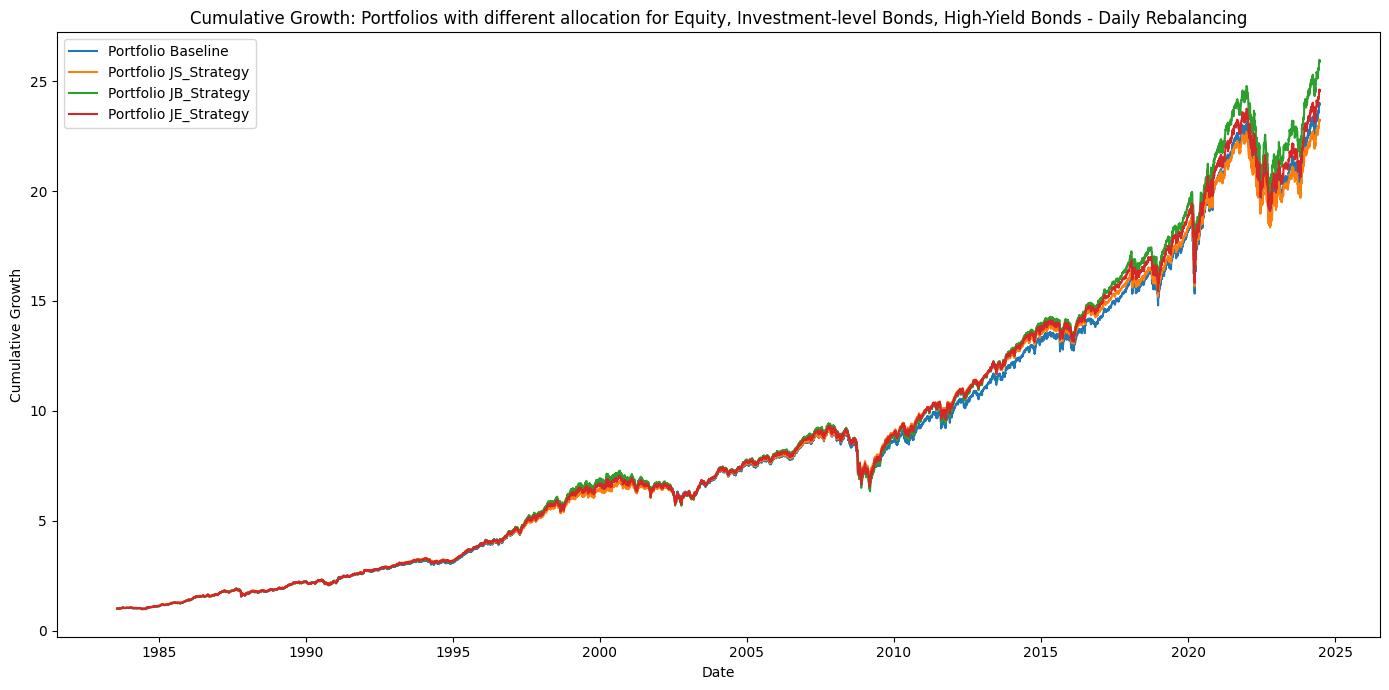

In [10]:
daily_rebalancing_dict, daily_portfolio_daily_returns_dict = backtest_portfolios_daily(allocations_df, start_date, end_date, title='Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds - Daily Rebalancing')

In [11]:
# Iterate over each allocation's returns and calculate performance metrics
performance_metrics = {}
for allocation_name, returns in daily_rebalancing_dict.items():
    performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,22.965764,0.056554,0.076532,0.73896,-0.299707,2009-03-09
JS_Strategy,22.220781,0.055105,0.063592,0.866547,-0.2653,2009-03-09
JB_Strategy,24.927154,0.057928,0.077128,0.751065,-0.327925,2009-03-09
JE_Strategy,23.581443,0.056517,0.070252,0.804487,-0.29682,2009-03-09


### Rebalance With Customized Frequency

##### Monthly

In [12]:
def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M', title = ""):
    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        agg.ffill(inplace=True)
        jnk.ffill(inplace=True)
        spy.ffill(inplace=True)
        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Initialize portfolio values and weights
        portfolio_value = 1.0
        portfolio_values = [portfolio_value]
        portfolio_daily_returns = []

        # Initialize weights
        weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])

        # Rebalance dates based on the specified frequency
        rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

        for i, date in enumerate(combined_index):
            if date in rebalance_dates:
                # Rebalance the portfolio
                total_value = (
                    weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
                    weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
                    weights[2] * agg_backtest.loc[date]['LAST_PRICE']
                )
                weights = np.array([
                    allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
                    allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
                    allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
                ])
                weights /= weights.sum()  # Normalize weights to sum to 1

            if i > 0:  # Skip the first day
                # Calculate portfolio return
                daily_returns = np.array([
                    spy_backtest.loc[date]['DailyReturn'],
                    jnk_backtest.loc[date]['DailyReturn'],
                    agg_backtest.loc[date]['DailyReturn']
                ])
                portfolio_return = np.dot(weights, daily_returns)
                portfolio_value *= (1 + portfolio_return)

                portfolio_values.append(portfolio_value)
                portfolio_daily_returns.append(portfolio_return)

        cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index[1:]))
        portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index[1:])

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(cumulative_product.index, cumulative_product, label=f'Portfolio {allocation_name}')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Growth')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return cumulative_product_dict, portfolio_daily_returns_dict
    # return portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values

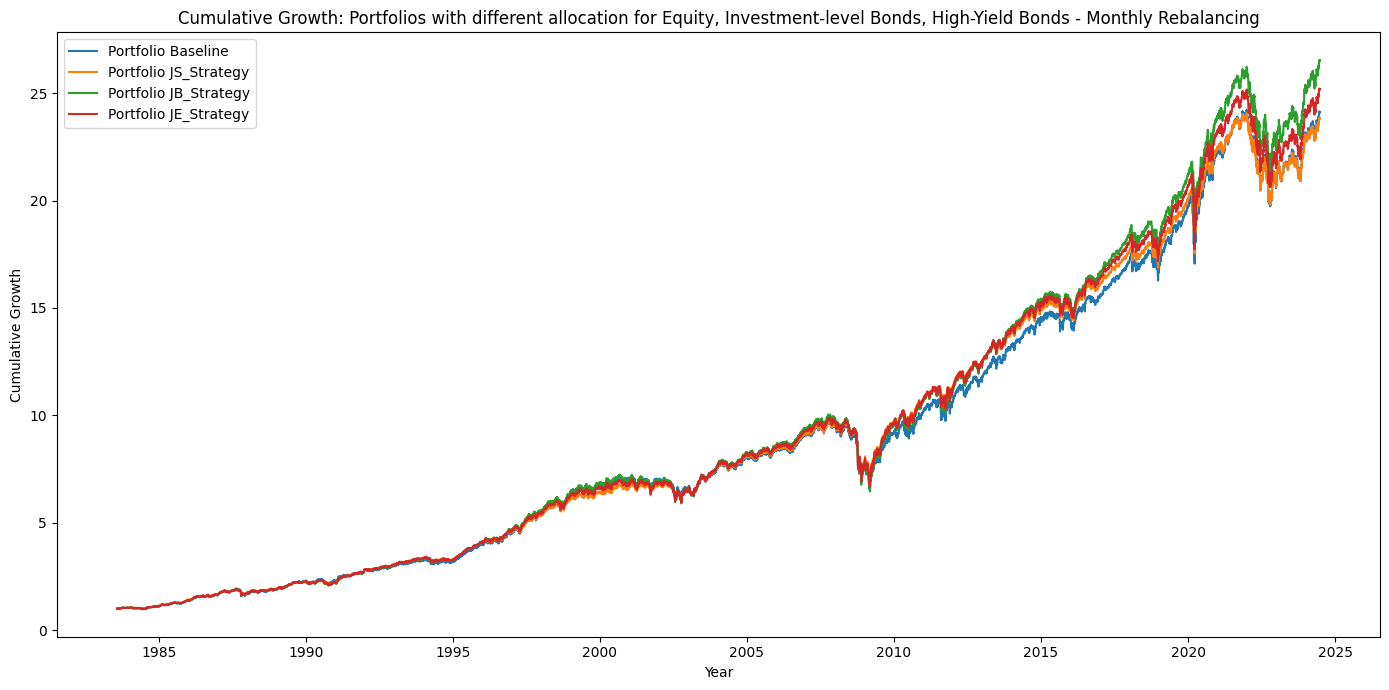

In [13]:
monthly_rebalancing_dict, monthly_portfolio_daily_returns_dict = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='M', 
                                               title = 'Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds - Monthly Rebalancing' )



In [14]:
# Iterate over each allocation's returns and calculate performance metrics
monthly_performance_metrics = {}
for allocation_name, returns in monthly_rebalancing_dict.items():
    monthly_performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
monthly_performance_df = pd.DataFrame(monthly_performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
monthly_performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,23.116979,0.056682,0.077177,0.734437,-0.336448,2009-03-09
JS_Strategy,22.847339,0.055415,0.061731,0.897698,-0.297619,2009-03-09
JB_Strategy,25.523506,0.058056,0.074137,0.783098,-0.353388,2009-03-09
JE_Strategy,24.189519,0.056737,0.067842,0.836306,-0.325929,2009-03-09


#### Semi-Annually

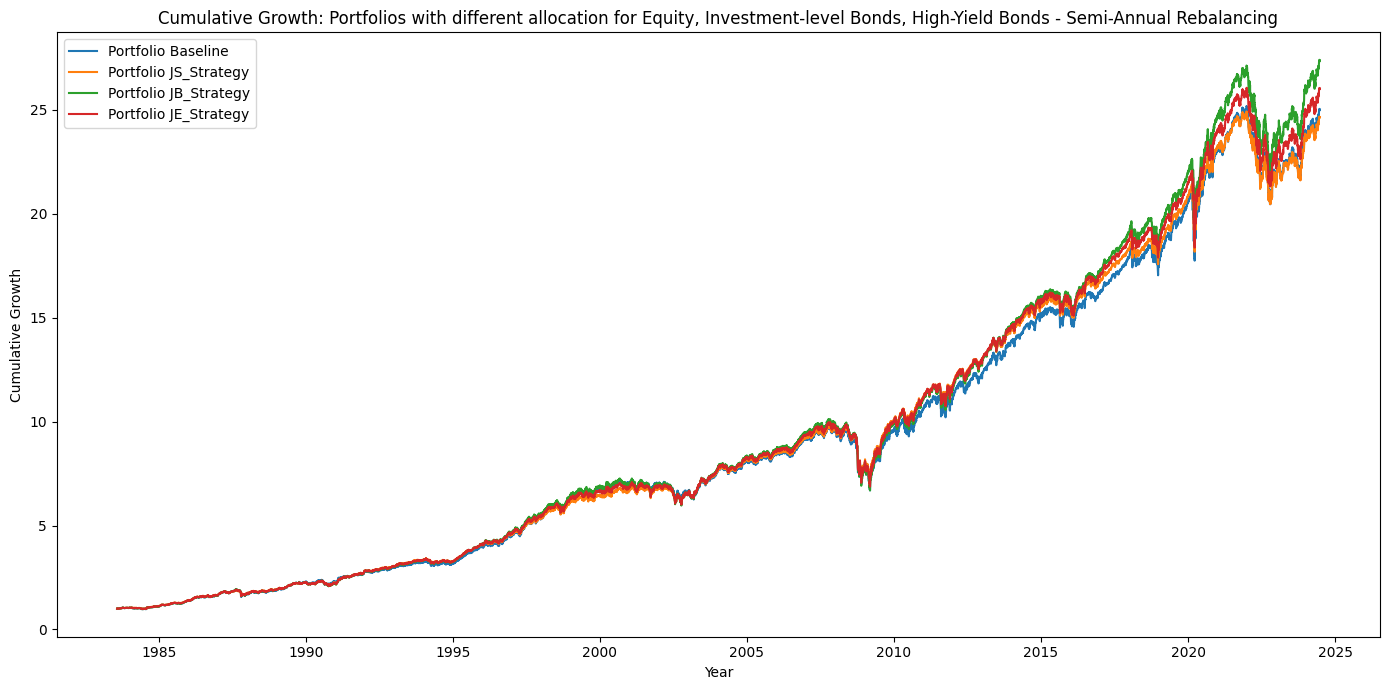

In [15]:
semi_annual_rebalancing_dict, semi_annual_portfolio_daily_returns_dict = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='6M', 
                                                   title = 'Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds - Semi-Annual Rebalancing' )

In [16]:
# Iterate over each allocation's returns and calculate performance metrics
semi_annual_performance_metrics = {}
for allocation_name, returns in semi_annual_rebalancing_dict.items():
    semi_annual_performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
semi_annual_performance_df = pd.DataFrame(semi_annual_performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
semi_annual_performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,24.015886,0.057213,0.076058,0.752228,-0.316394,2009-03-09
JS_Strategy,23.654514,0.055926,0.060906,0.918239,-0.280753,2009-03-09
JB_Strategy,26.380694,0.058531,0.073299,0.798521,-0.338227,2009-03-09
JE_Strategy,25.030513,0.057234,0.066998,0.854264,-0.309747,2009-03-09


In [41]:
semi_annual_portfolio_daily_returns_dict

{'Baseline': Date
 1983-08-02   -0.000093
 1983-08-03    0.004413
 1983-08-04   -0.006455
 1983-08-05    0.001271
 1983-08-06    0.000000
                 ...   
 2024-06-21   -0.000339
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000367
 2024-06-25    0.001282
 Length: 14939, dtype: float64,
 'JS_Strategy': Date
 1983-08-02   -0.000074
 1983-08-03    0.003531
 1983-08-04   -0.005164
 1983-08-05    0.001017
 1983-08-06    0.000000
                 ...   
 2024-06-21   -0.000202
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000065
 2024-06-25    0.001019
 Length: 14939, dtype: float64,
 'JB_Strategy': Date
 1983-08-02   -0.000093
 1983-08-03    0.004413
 1983-08-04   -0.006455
 1983-08-05    0.001271
 1983-08-06    0.000000
                 ...   
 2024-06-21   -0.000338
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000364
 2024-06-25    0.001315
 Length: 14939, dtype: float64,
 'JE_Strategy': Date
 1983-08-02   -0.000083
 1983-0

In [51]:
# asset_class_daily_returns_df = backtest_portfolios_asset_class_ret(allocations_df, start_date, end_date, rebalance_freq='6M')

In [52]:
# asset_class_daily_returns_df

{'Baseline':             Equities  HighYieldBonds  InvGradeBonds
 Dates                                              
 1983-08-02 -0.000185        0.000000       0.000000
 1983-08-03  0.008827        0.000000       0.000000
 1983-08-04 -0.012910        0.000000       0.000000
 1983-08-05  0.002541        0.000000       0.000000
 1983-08-06  0.000000        0.000000       0.000000
 ...              ...             ...            ...
 2024-06-21 -0.001562        0.000267       0.000171
 2024-06-22  0.000000        0.000000       0.000000
 2024-06-23  0.000000        0.000000       0.000000
 2024-06-24 -0.003065        0.000967       0.000759
 2024-06-25  0.003934        0.000259       0.000176
 
 [14939 rows x 3 columns],
 'JS_Strategy':             Equities  HighYieldBonds  InvGradeBonds
 Dates                                              
 1983-08-02 -0.000185        0.000000       0.000000
 1983-08-03  0.008827        0.000000       0.000000
 1983-08-04 -0.012910        0.000000      

In [44]:
# Convert the dictionary to a DataFrame
semi_annual_portfolio_daily_returns_df = pd.DataFrame(semi_annual_portfolio_daily_returns_dict)

# Display the DataFrame
semi_annual_portfolio_daily_returns_df.to_csv('./Output/semi_annual_portfolio_daily_returns.csv')

#### Annually

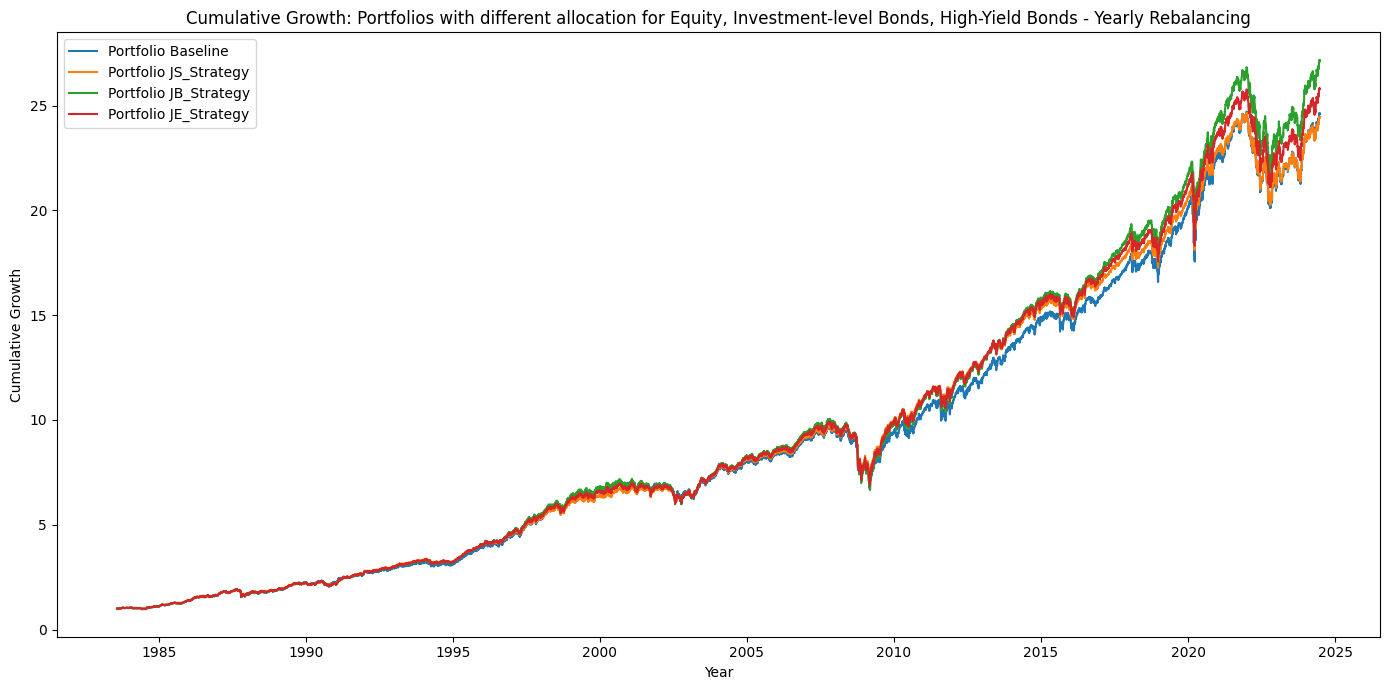

In [17]:
yearly_rebalancing_dict, yearly_portfolio_daily_returns_dict = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='Y',
                                               title = 'Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds - Yearly Rebalancing' )

In [18]:
# Iterate over each allocation's returns and calculate performance metrics
yearly_performance_metrics = {}
for allocation_name, returns in yearly_rebalancing_dict.items():
    yearly_performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
yearly_performance_df = pd.DataFrame(yearly_performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
yearly_performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Baseline,23.615579,0.056918,0.075704,0.751841,-0.313935,2009-03-09
JS_Strategy,23.441279,0.055756,0.060492,0.921719,-0.27761,2009-03-09
JB_Strategy,26.149999,0.058356,0.072814,0.801437,-0.335172,2009-03-09
JE_Strategy,24.80391,0.057058,0.066544,0.857454,-0.306624,2009-03-09


In [19]:
# Add a column to identify the strategy
performance_df['Strategy'] = 'Buy and Hold'
monthly_performance_df['Strategy'] = 'Monthly Rebalance'
semi_annual_performance_df['Strategy'] = 'Semi-Annual Rebalance'
yearly_performance_df['Strategy'] = 'Annual Rebalance'

# Concatenate the DataFrames
combined_performance_df = pd.concat([performance_df, monthly_performance_df, semi_annual_performance_df, yearly_performance_df])

# Reset the index to have a clean DataFrame
combined_performance_df.reset_index(inplace=True)

combined_performance_df.head(5)

,index,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date,Strategy
0,Baseline,22.965764,0.056554,0.076532,0.73896,-0.299707,2009-03-09,Buy and Hold
1,JS_Strategy,22.220781,0.055105,0.063592,0.866547,-0.2653,2009-03-09,Buy and Hold
2,JB_Strategy,24.927154,0.057928,0.077128,0.751065,-0.327925,2009-03-09,Buy and Hold
3,JE_Strategy,23.581443,0.056517,0.070252,0.804487,-0.29682,2009-03-09,Buy and Hold
4,Baseline,23.116979,0.056682,0.077177,0.734437,-0.336448,2009-03-09,Monthly Rebalance


In [20]:
def enhanced_bar_plot(x, y, data, hue='index', palette='viridis', title='Comparison Across Strategies', ylabel='Value'):
    plt.figure(figsize=(10, 4))
    sns.set(style="whitegrid")

    # Create the bar plot
    bar_plot = sns.barplot(x=x, y=y, hue=hue, data=data, palette=palette)

    # Add value labels to each bar
    for p in bar_plot.patches:
        height = p.get_height()
        if height != 0:  # Annotate bars with height not equal to 0
            bar_plot.annotate(format(height, '.2f'), 
                              (p.get_x() + p.get_width() / 2., height), 
                              ha='center', va='center', 
                              xytext=(0, 9 if height > 0 else -9),  # Adjust text position based on height
                              textcoords='offset points')

    # Customize the title and labels
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(xlabel ='', fontsize=11)
    plt.ylabel(ylabel, fontsize=12)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), fontsize= 10)
    plt.legend(title='Allocation', title_fontsize='10', fontsize='9', loc='center left', bbox_to_anchor=(1, 0.5))
    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [22]:
def enhanced_bar_plot(x, y, data, hue='index', palette='viridis', title='Comparison Across Strategies', ylabel='Value'):
    plt.figure(figsize=(10, 4))
    sns.set(style="whitegrid")

    # Create the bar plot
    bar_plot = sns.barplot(x=x, y=y, hue=hue, data=data, palette=palette, dodge=True, ci=None, width=0.93)

    # Add value labels to each bar with reduced font size
    for p in bar_plot.patches:
        height = p.get_height()
        if height != 0:  # Annotate bars with height not equal to 0
            bar_plot.annotate(format(height, '.2f'), 
                              (p.get_x() + p.get_width() / 2., height), 
                              ha='center', va='center', 
                              xytext=(0, 5 if height > 0 else -5),  # Adjust text position based on height
                              textcoords='offset points',
                              fontsize=11, 
                              fontweight='bold')  # Reduce font size

    # Customize the title and labels
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(xlabel ='', fontsize=11)
    plt.ylabel(ylabel, fontsize=12)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), fontsize= 10)
    plt.legend(title='Allocation', title_fontsize='10', fontsize='9', loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Increase the margin to avoid overlap
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()


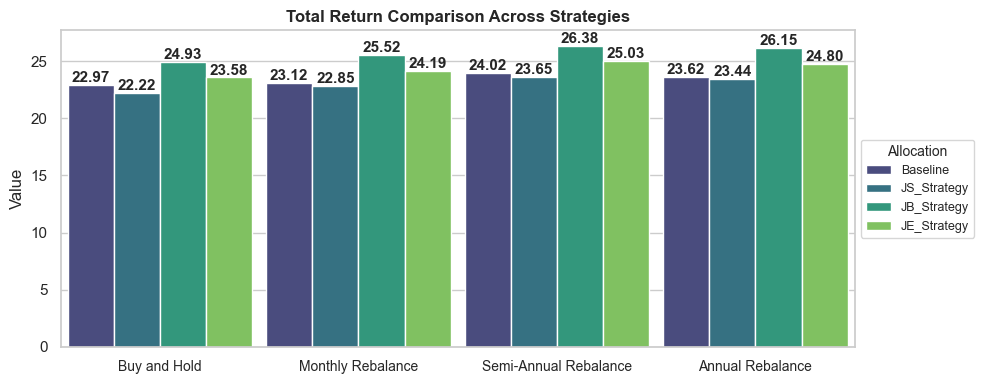

In [23]:
enhanced_bar_plot(x='Strategy', y='Total Return', title='Total Return Comparison Across Strategies', data=combined_performance_df)

In [24]:
def pct_enhanced_bar_plot(x, y, data, hue='index', palette='viridis', title='Comparison Across Strategies', ylabel='Value'):
    plt.figure(figsize=(10, 4))
    sns.set(style="whitegrid")

    # Create the bar plot
    bar_plot = sns.barplot(x=x, y=y, hue=hue, data=data, palette=palette, dodge=True, ci=None, width=0.93)

    # Add value labels to each bar with reduced font size
    for p in bar_plot.patches:
        height = p.get_height()
        if height != 0:  # Annotate bars with height not equal to 0
            bar_plot.annotate(f'{height * 100:.2f}%',  # Convert to percentage and format
                              (p.get_x() + p.get_width() / 2., height), 
                              ha='center', va='center', 
                              xytext=(0, 5 if height > 0 else -5),  # Adjust text position based on height
                              textcoords='offset points',
                              fontsize=11,
                              fontweight='bold')  # Reduce font size

    # Customize the title and labels
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(xlabel ='', fontsize=11)
    plt.ylabel(ylabel, fontsize=12)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), fontsize= 10)
    plt.legend(title='Allocation', title_fontsize='10', fontsize='9', loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Increase the margin to avoid overlap
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()

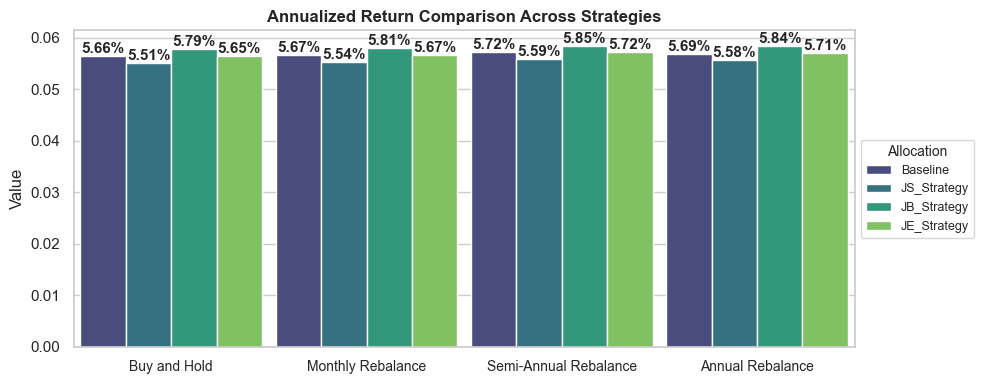

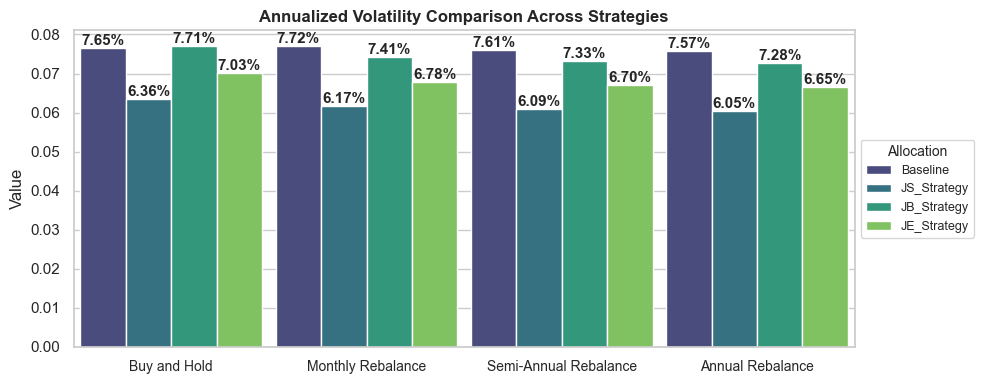

In [25]:
pct_enhanced_bar_plot(x='Strategy', y='Annualized Return', title='Annualized Return Comparison Across Strategies', data=combined_performance_df)
pct_enhanced_bar_plot(x='Strategy', y='Annualized Volatility', title='Annualized Volatility Comparison Across Strategies', data=combined_performance_df)

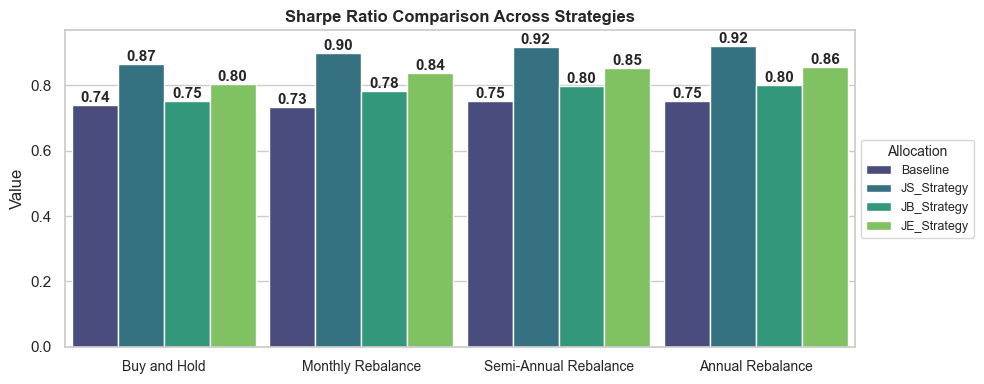

In [26]:
enhanced_bar_plot(x='Strategy', y='Sharpe Ratio', title='Sharpe Ratio Comparison Across Strategies', data=combined_performance_df)

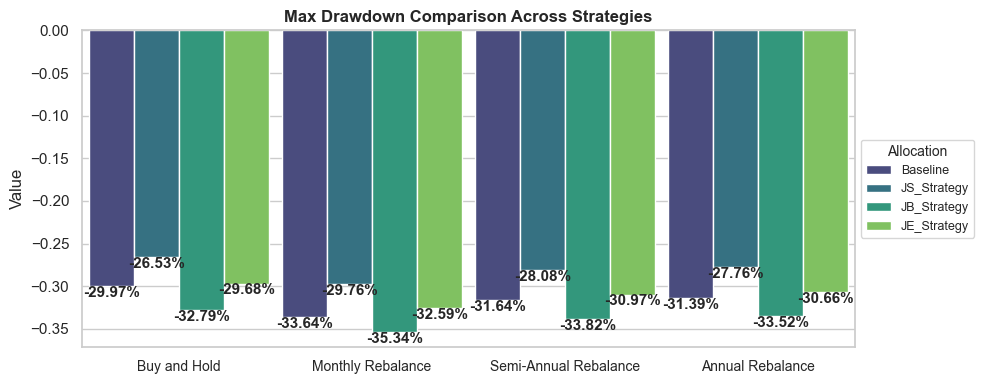

In [27]:
pct_enhanced_bar_plot(x='Strategy', y='Max Drawdown', title='Max Drawdown Comparison Across Strategies', data=combined_performance_df)

In [28]:
def visualization(returns, window=126, top_n=5, strategy_name=''):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import plotly.graph_objs as go
    from matplotlib.ticker import FuncFormatter

    # Plot Rolling Sharpe Ratio # to be continued
    def plot_rolling_sharpe_ratio(returns, window=126, strategy_name=''):
        rolling_sharpe = (returns.rolling(window).mean() / returns.rolling(window).std()) * np.sqrt(252)
        mean_sharpe = rolling_sharpe.mean()
        
        plt.figure(figsize=(12, 6))
        plt.plot(returns.index, rolling_sharpe, label='Rolling Sharpe Ratio')
        plt.axhline(mean_sharpe, color='red', linestyle='--', label='Mean Sharpe Ratio')
        plt.title(f'Rolling Sharpe Ratio (6-month) - {strategy_name}')
        plt.xlabel('Date')
        plt.ylabel('Sharpe Ratio')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plot Top Drawdowns
    def plot_top_drawdowns(returns, top_n=5, strategy_name=''):
        cumulative_return = (1 + returns).cumprod()
        running_max = cumulative_return.cummax()
        drawdown = (cumulative_return - running_max) / running_max
        drawdown_periods = drawdown[drawdown < 0].groupby((drawdown == 0).cumsum()).min().nsmallest(top_n)
        
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_return, label='Portfolio')
        plt.title(f'Top {top_n} Drawdown Periods - {strategy_name}')
        plt.ylabel('Cumulative returns')
        plt.legend()
        colors = sns.color_palette("Purples", top_n)[::-1]
        for i, period in enumerate(drawdown_periods.index):
            if period - 1 < len(drawdown[drawdown == 0].index):
                start = drawdown[drawdown == 0].index[period - 1]
                end = drawdown[drawdown == 0].index[period] if period < len(drawdown[drawdown == 0].index) else drawdown.index[-1]
                plt.axvspan(start, end, color=colors[i], alpha=0.3)
        plt.show()

    # Plot Underwater
    def plot_underwater(returns, strategy_name=''):
        cumulative_return = (1 + returns).cumprod()
        running_max = cumulative_return.cummax()
        drawdown = (cumulative_return - running_max) / running_max
        plt.figure(figsize=(12, 4))
        plt.fill_between(drawdown.index, drawdown * 100, color='#FF4500', alpha=0.5)
        plt.title(f'Underwater Plot - {strategy_name}')
        plt.ylabel('Drawdown')
        plt.xlabel('Date')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
        plt.show()

    # Plot Returns Analysis
    def plot_returns_analysis(returns, strategy_name=''):
        # Calculate monthly returns
        monthly_returns = returns.resample('M').sum()
        monthly_returns_pct = monthly_returns * 100

        # Calculate annual returns
        annual_returns = returns.resample('Y').sum()
        annual_returns_pct = annual_returns * 100

        # Calculate distribution of monthly returns
        monthly_returns_distribution = monthly_returns_pct

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))

        # Plot annual returns bar chart
        annual_returns_df = annual_returns_pct.to_frame(name='Returns').reset_index()
        annual_returns_df['Year'] = annual_returns_df['Date'].dt.year
        annual_returns_df.set_index('Year', inplace=True)
        annual_returns_df['Returns'].plot(kind='barh', ax=axes[0], color='skyblue')
        axes[0].axvline(annual_returns_pct.mean(), color='orange', linestyle='--', linewidth=2, label='mean')
        axes[0].set_title(f'Annual Returns ({strategy_name})', fontsize = 25)
        axes[0].set_xlabel('Returns', fontsize = 20)
        axes[0].set_ylabel('Year', fontsize = 20)
        axes[0].legend(fontsize = 20)
        axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
        axes[0].tick_params(axis='x', labelsize=15)  # Increase x-axis tick label size
        axes[0].tick_params(axis='y', labelsize=12)  # Increase y-axis tick label size

        # Plot distribution of monthly returns histogram
        monthly_returns_distribution.plot(kind='hist', bins=20, ax=axes[1], color='coral', edgecolor='black')
        axes[1].axvline(monthly_returns_distribution.mean(), color='orange', linestyle='--', linewidth=2, label='mean')
        axes[1].set_title(f'Distribution of Monthly Returns ({strategy_name})', fontsize = 25)
        axes[1].set_xlabel('Returns', fontsize = 20)
        axes[1].set_ylabel('Number of months', fontsize = 20)
        axes[1].legend(fontsize = 20)
        axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
        axes[1].tick_params(axis='x', labelsize=15)  # Increase x-axis tick label size
        axes[1].tick_params(axis='y', labelsize=12)  # Increase y-axis tick label size

        plt.tight_layout()
        plt.show()
        
    # Call the individual plotting functions
    plot_rolling_sharpe_ratio(returns, window, strategy_name)
    plot_top_drawdowns(returns, top_n, strategy_name)
    plot_underwater(returns, strategy_name)
    plot_returns_analysis(returns, strategy_name)

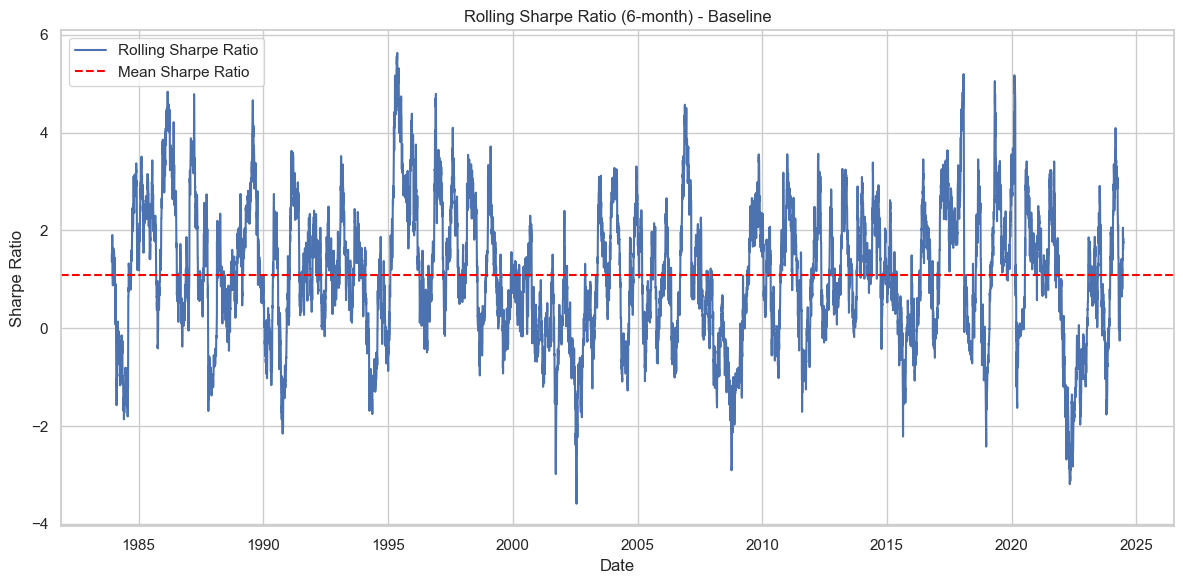

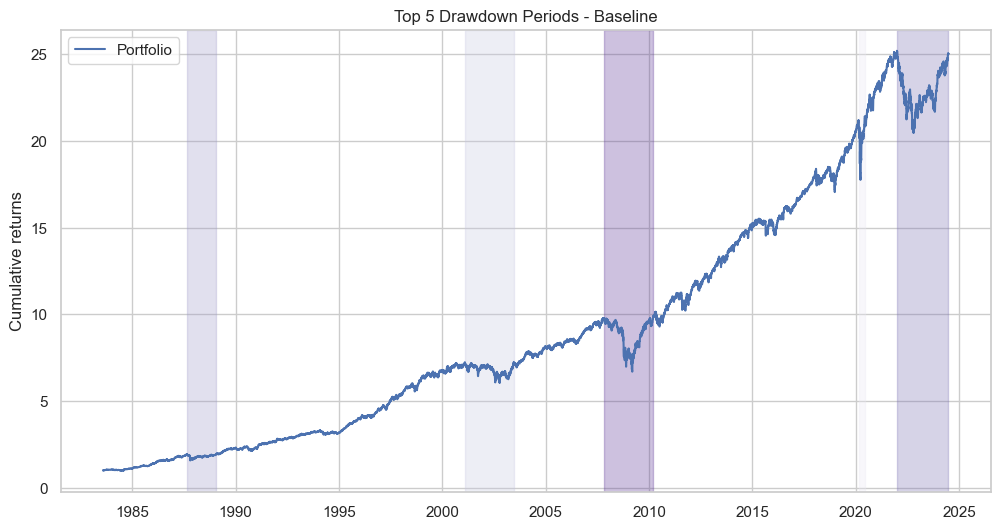

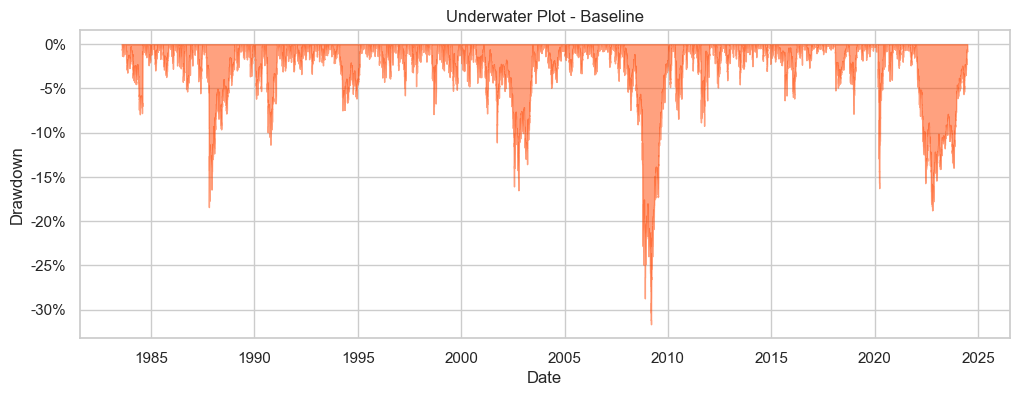

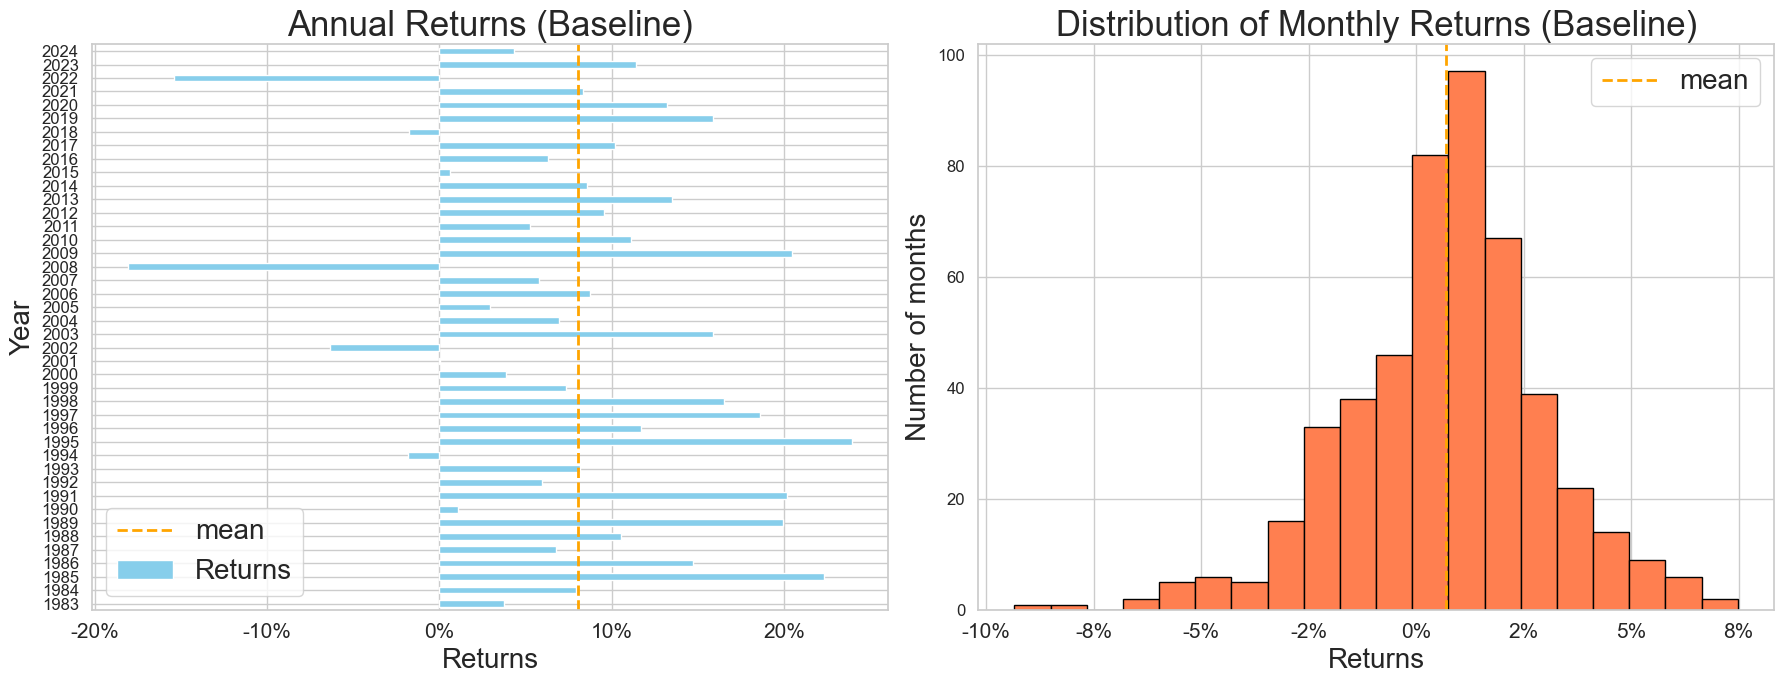

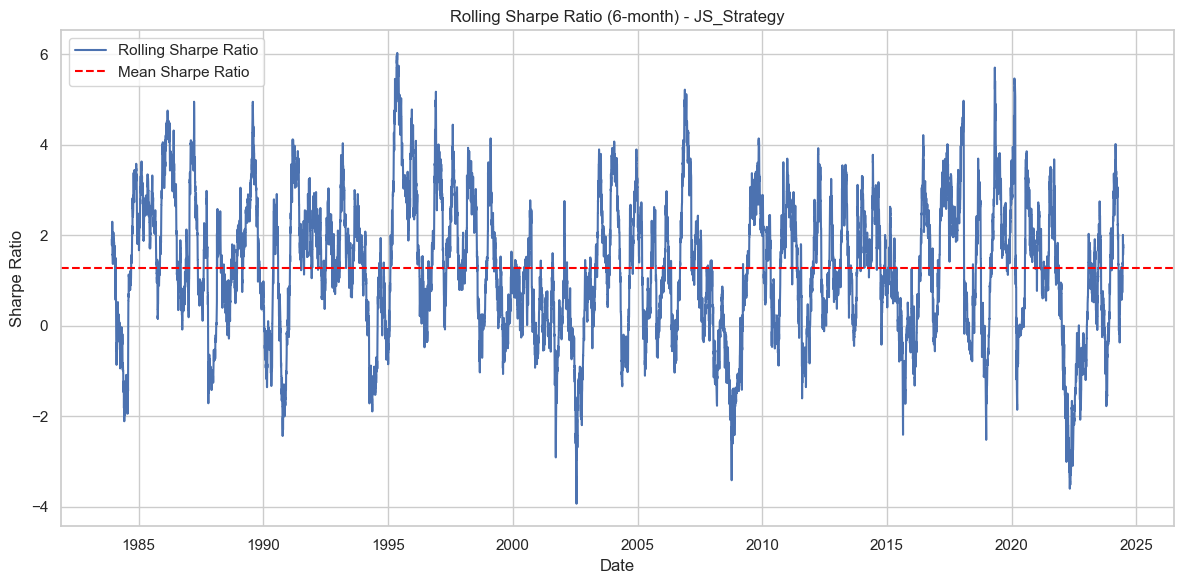

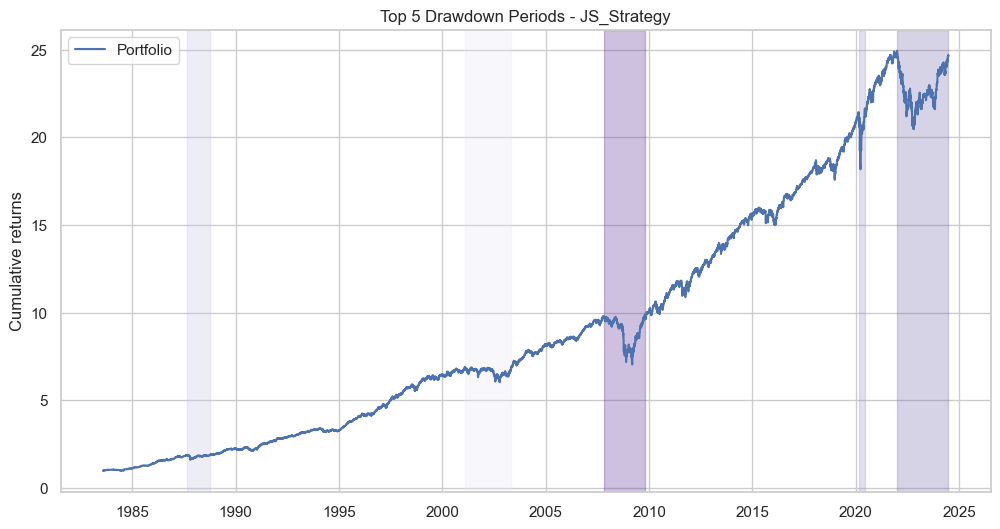

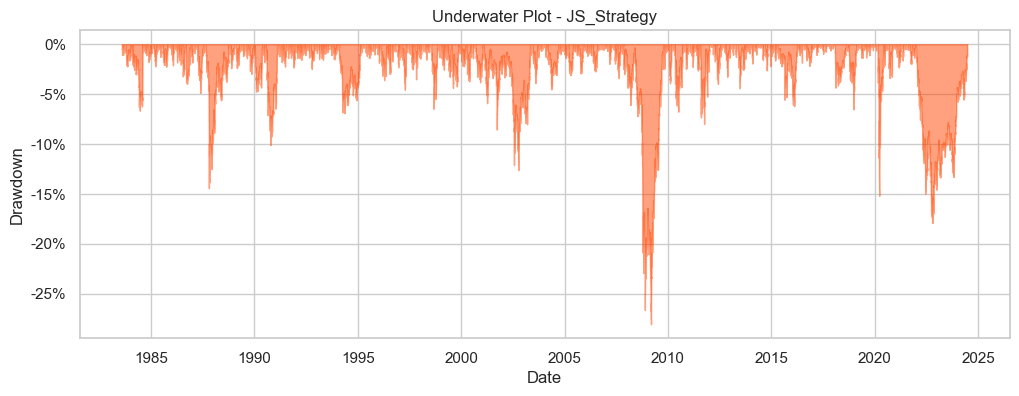

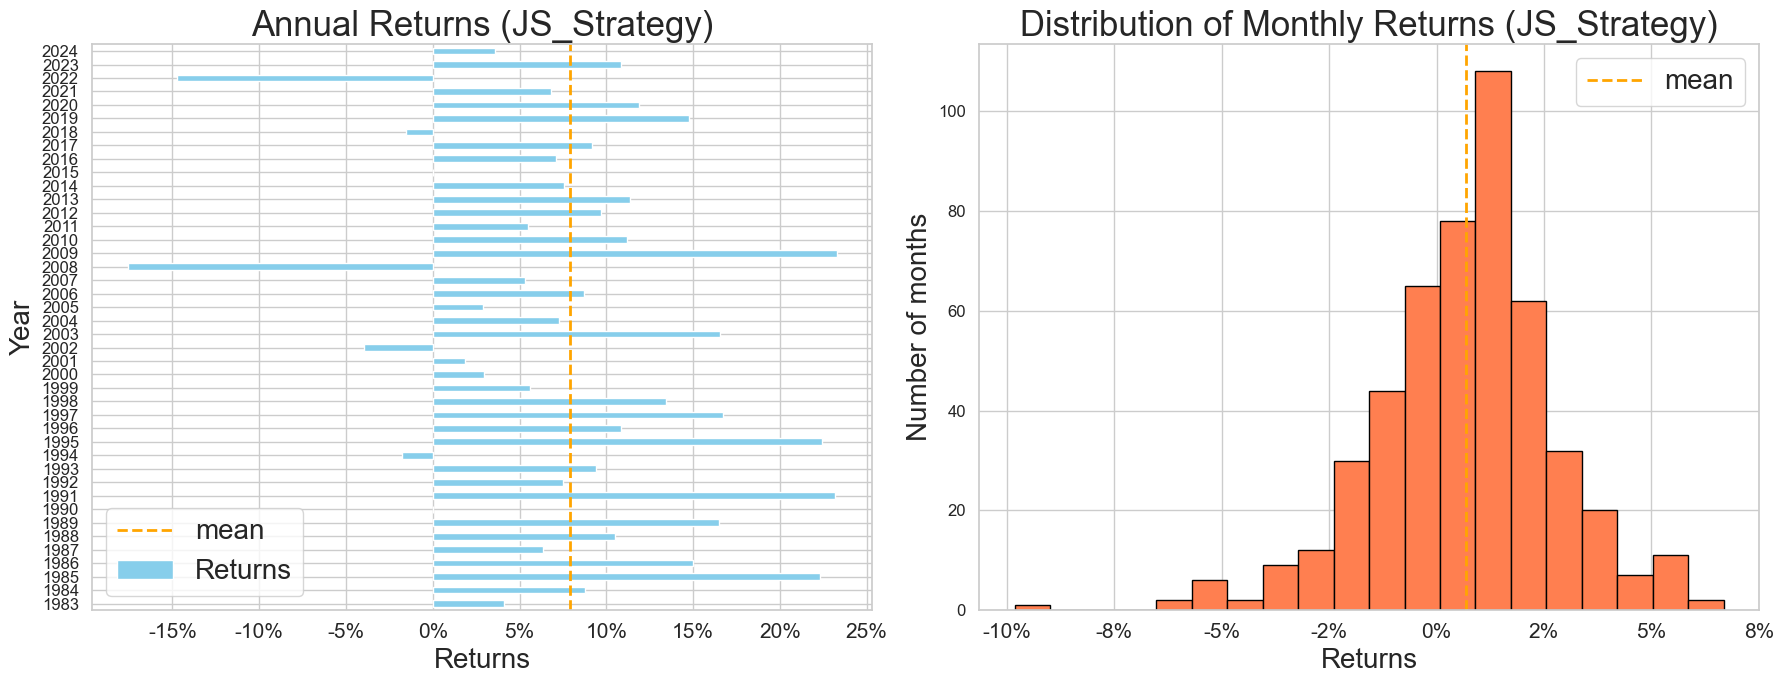

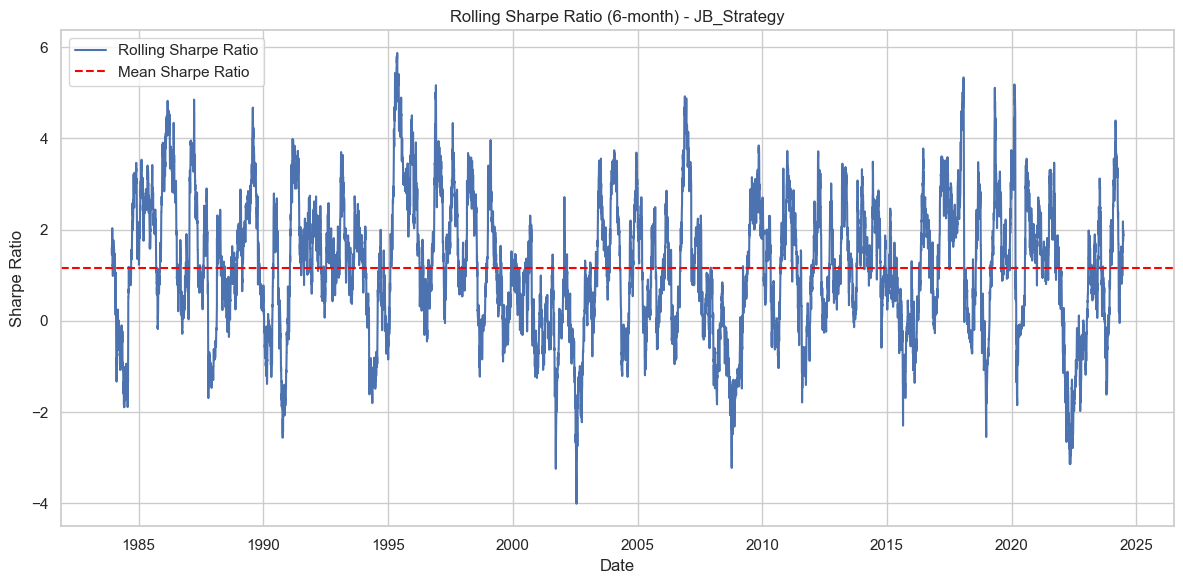

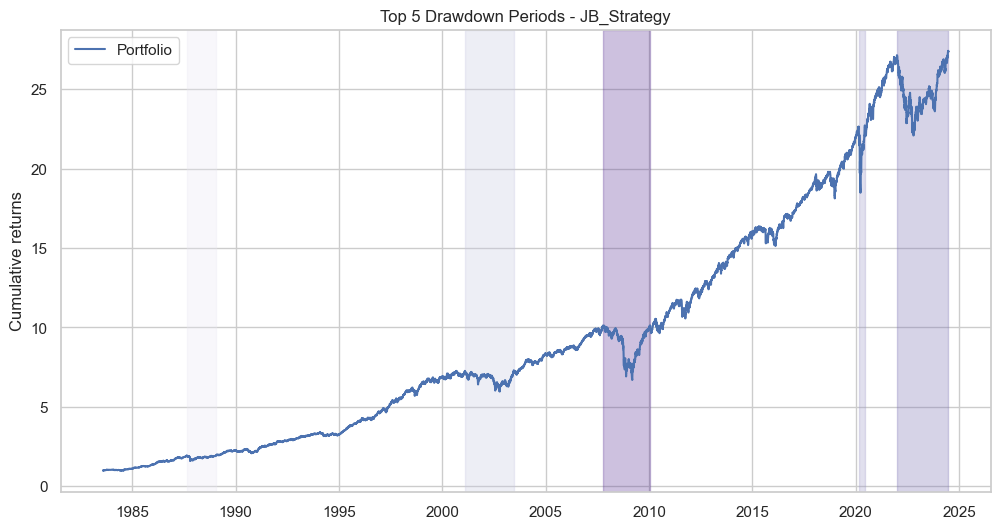

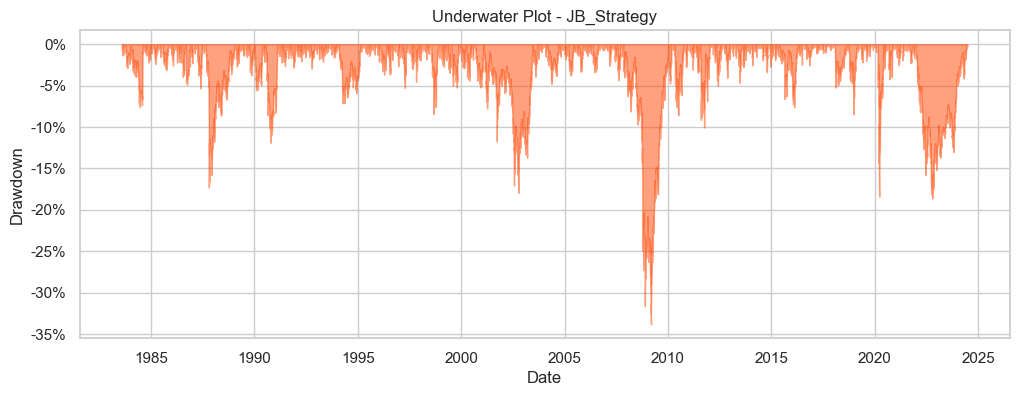

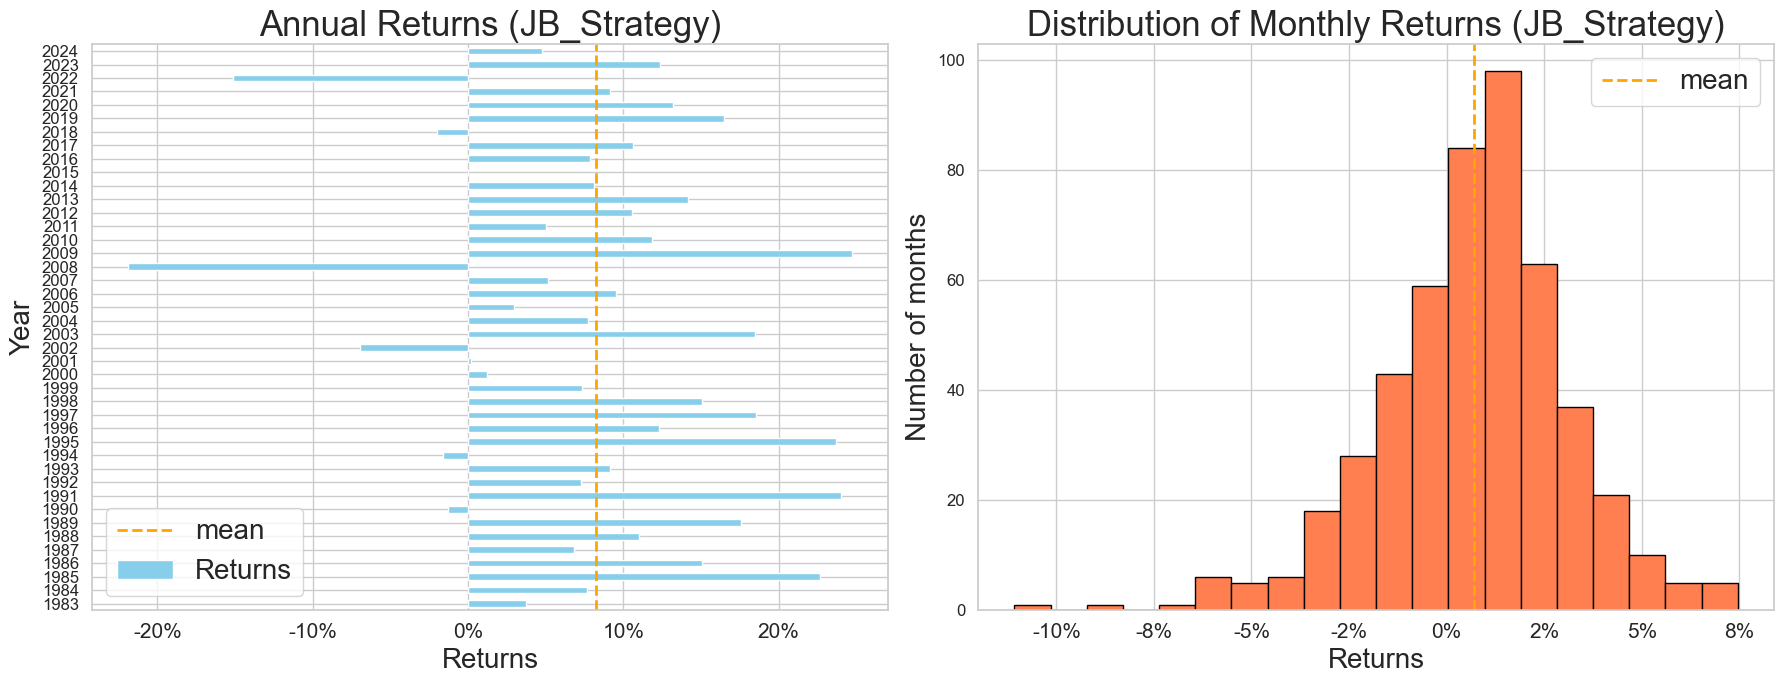

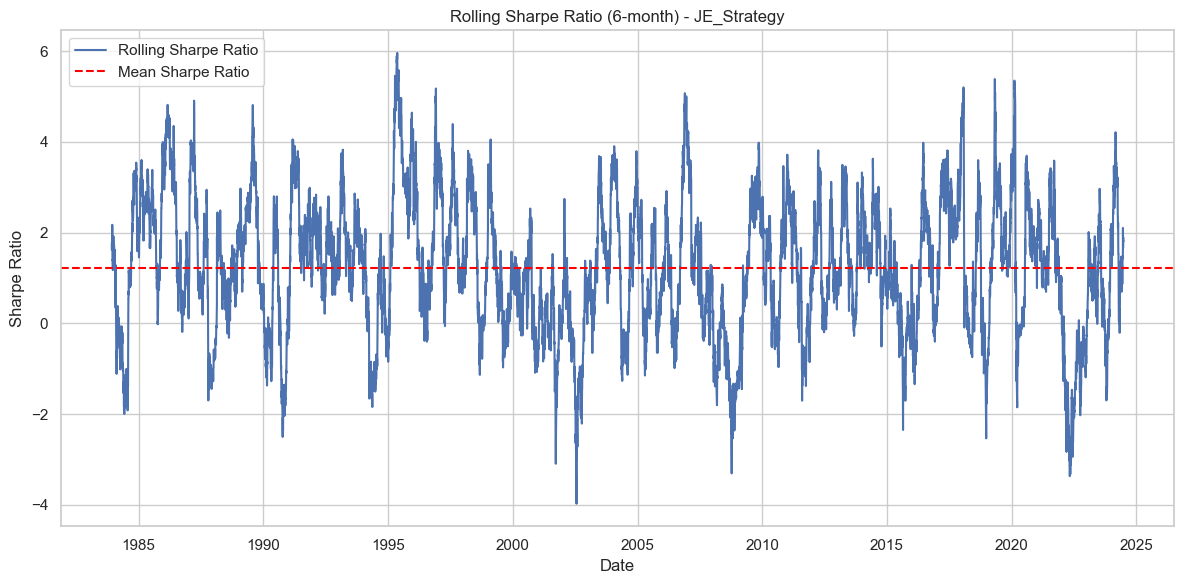

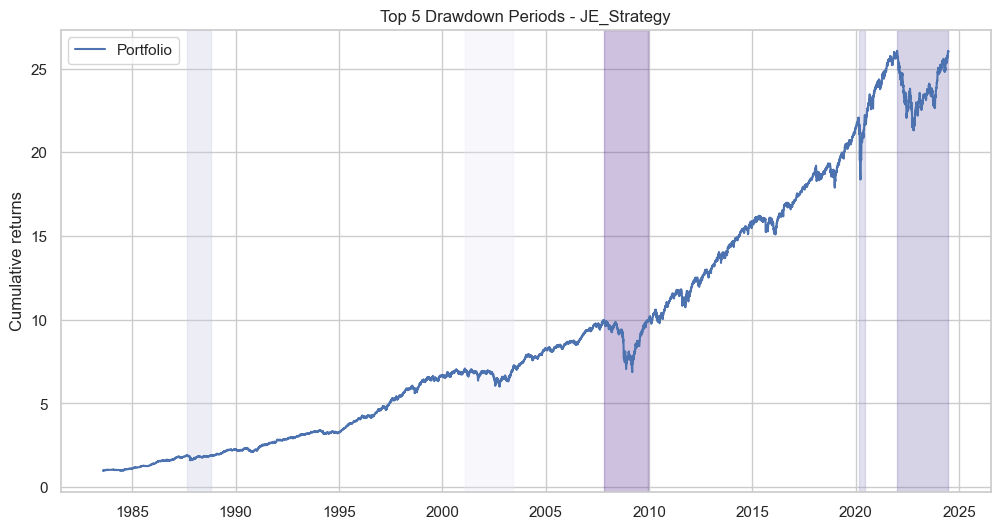

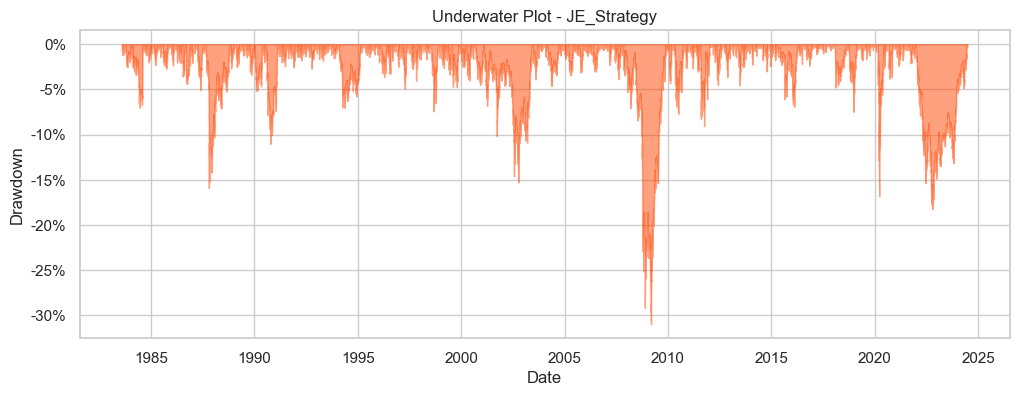

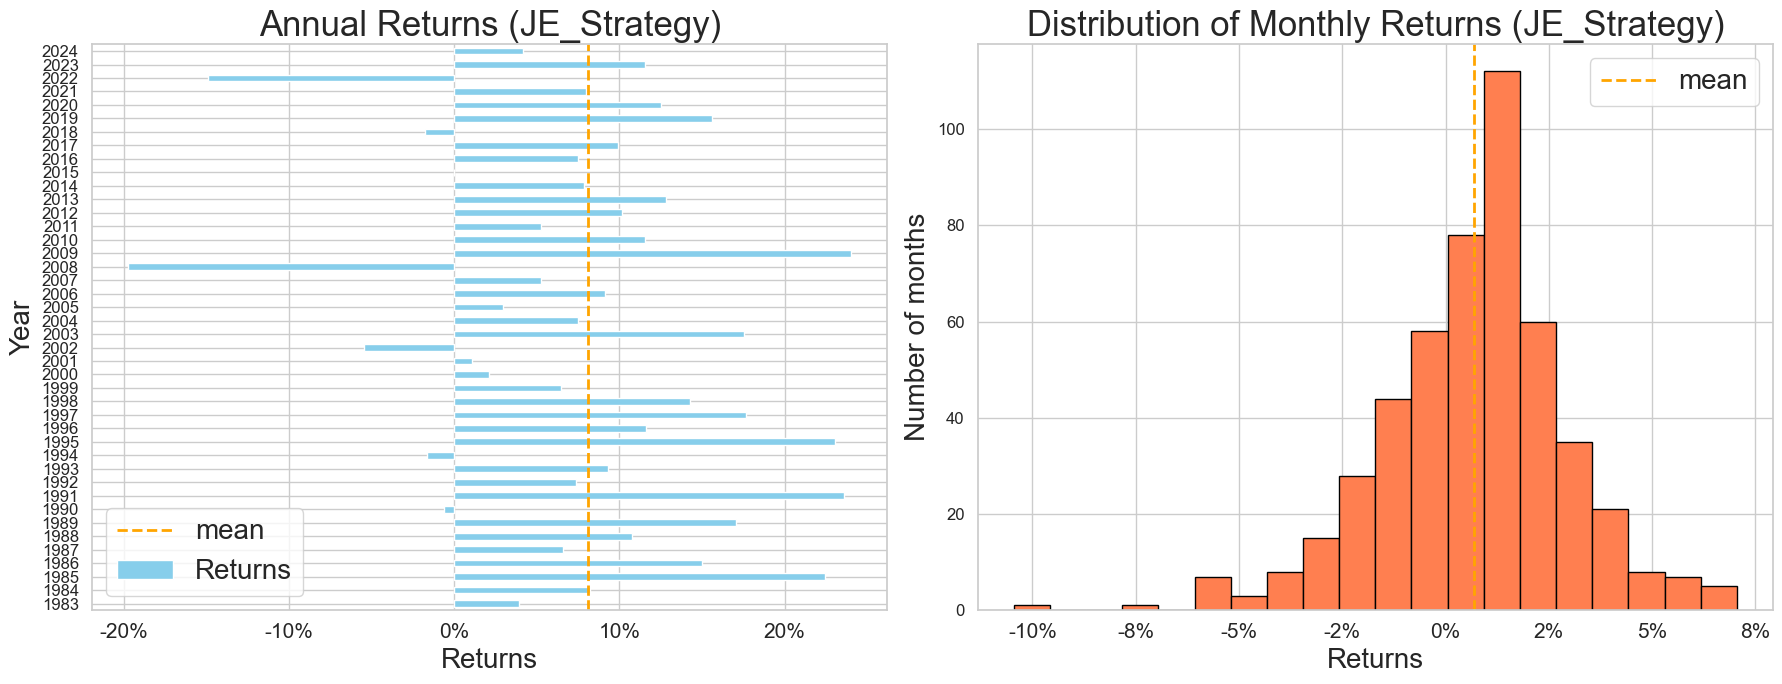

In [29]:
for allocation_name, daily_returns in semi_annual_portfolio_daily_returns_dict.items():
    # Ensure the index is set to 'Dates'
    daily_returns.index.name = 'Date'
    visualization(daily_returns, strategy_name = allocation_name)

Using the Semi-Annual Rebalancing Result

##### Baseline Strategy
'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50

A series of charts to look at would be plotting baseline returns (x-axis) against strategy returns (y-axis) – one chart for each strategy. Here we’ll get a sense of when the strategy does better or worse than the baseline.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_baseline_vs_strategy_time_series(baseline_returns, strategy_returns_dict, title_prefix=''):
    sns.set(style="whitegrid")
    
    for strategy, returns in strategy_returns_dict.items():
        plt.figure(figsize=(14, 10))
        
        data = pd.DataFrame({
            'Date': baseline_returns.index,
            'Baseline Returns': baseline_returns,
            'Strategy Returns': returns
        })
        
        # Plot using seaborn
        sns.lineplot(data=data, x='Date', y='Baseline Returns', label='Baseline Returns', color='blue')
        sns.lineplot(data=data, x='Date', y='Strategy Returns', label=f'{strategy} Returns', color='green')
        
        plt.title(f'{title_prefix} Baseline vs {strategy} Returns Over Time', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Returns', fontsize=14)
        plt.legend(title='Returns')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [31]:
# pip install adjustText

In [32]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

def plot_baseline_vs_strategy(baseline_returns, strategy_returns_dict, title_prefix='', dot_size=40):
    sns.set(style="whitegrid")
    
    all_significant_points = []

    for strategy, returns in strategy_returns_dict.items():
        plt.figure(figsize=(6, 4))
        
        data = pd.DataFrame({
            'Date': baseline_returns.index,
            'Baseline Returns': baseline_returns,
            'Strategy Returns': returns
        })
        
        # Determine outperformance and underperformance
        data['Performance'] = ['Outperform' if sr > br else 'Underperform' for sr, br in zip(data['Strategy Returns'], data['Baseline Returns'])]
        
        # Plot using seaborn
        scatter_plot = sns.scatterplot(data=data, x='Baseline Returns', y='Strategy Returns', hue='Performance', 
                                       palette={'Outperform': 'red', 'Underperform': 'green'}, s=dot_size, alpha=0.4)
        
        # Line y=x for reference
        plt.plot([baseline_returns.min(), baseline_returns.max()], [baseline_returns.min(), baseline_returns.max()], 'r--', label='Baseline')
        
        # Annotate points with more than 2% difference and collect the data
        significant_points = []
        texts = []
        for i in range(len(data)):
            if abs(data['Strategy Returns'][i] - data['Baseline Returns'][i]) > 0.010:
                texts.append(scatter_plot.text(data['Baseline Returns'][i], data['Strategy Returns'][i],
                                               f"Date: {data['Date'][i].strftime('%Y-%m-%d')}\n"
                                               f"Baseline: {data['Baseline Returns'][i]:.2f}\n"
                                               f"Strategy: {data['Strategy Returns'][i]:.2f}",
                                               fontsize=8.5, color='black'))
                significant_points.append({
                    'Date': data['Date'][i].strftime('%Y-%m-%d'),
                    'Baseline Return': data['Baseline Returns'][i],
                    'Strategy Return': data['Strategy Returns'][i],
                    'Strategy': strategy
                })
        
        # Adjust text to minimize overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
        
        plt.title(f'{title_prefix} Baseline vs {strategy} Returns', fontsize=12)
        plt.xlabel('Baseline Returns', fontsize=11)
        plt.ylabel(f'{strategy}', fontsize=11)
        plt.legend(title='Performance', loc='upper left', title_fontsize=8, fontsize=7)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        all_significant_points.extend(significant_points)
    
    # Convert significant points to DataFrame
    significant_points_df = pd.DataFrame(all_significant_points)
    return significant_points_df

# Example usage
# plot_baseline_vs_strategy(baseline_portfolio_daily_returns_semi_annual, strategy_portfolio_daily_returns_dict_semi_annual, title_prefix='Portfolio Daily Return - ', dot_size=50)

In [33]:
import plotly.express as px
import pandas as pd

def plot_baseline_vs_strategy_interactive(baseline_returns, strategy_returns_dict, title_prefix=''):
    for strategy, returns in strategy_returns_dict.items():
        data = pd.DataFrame({
            'Date': baseline_returns.index,  # Include the date
            'Baseline Returns': baseline_returns.values,
            'Strategy Returns': returns.values
        })
        
        # Determine outperformance and underperformance
        data['Performance'] = ['Outperform' if sr > br else 'Underperform' for sr, br in zip(data['Strategy Returns'], data['Baseline Returns'])]
        
        # Format the date to remove T00:00:00
        data['Formatted Date'] = data['Date'].dt.strftime('%Y-%m-%d')
        
        # Create interactive scatter plot using Plotly
        fig = px.scatter(data, x='Baseline Returns', y='Strategy Returns', color='Performance',
                         color_discrete_map={'Outperform': 'lightcoral', 'Underperform': 'lightgreen'},
                         title=f'{title_prefix} Baseline vs {strategy} Returns',
                         labels={'Baseline Returns': 'Baseline Returns', 'Strategy Returns': f'{strategy} Returns'},
                         hover_data={'Formatted Date': True, 'Baseline Returns': ':.2f', 'Strategy Returns': ':.2f'},
                         opacity=0.7,  # Set transparency to see overlapping points
                         size_max=12)  # Increase the size of the points
        
        # Add line y=x for reference
        fig.add_shape(type='line', x0=baseline_returns.min(), y0=baseline_returns.min(), 
                      x1=baseline_returns.max(), y1=baseline_returns.max(),
                      line=dict(color='RoyalBlue', dash='dash'))
        
        fig.update_layout(title_font_size=16, xaxis_title_font_size=14, yaxis_title_font_size=14, legend_title_font_size=12,
                          width=900, height=600)  # Set consistent size
        fig.show()

- Outperformance: When the strategy returns are greater than the baseline returns.
- Underperformance: When the strategy returns are less than the baseline returns.

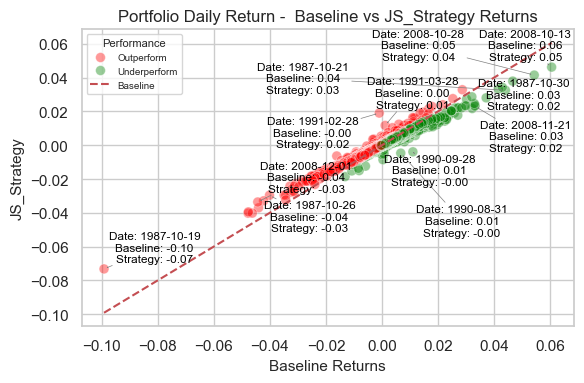

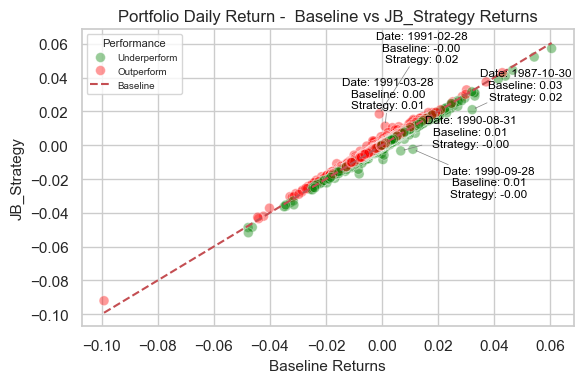

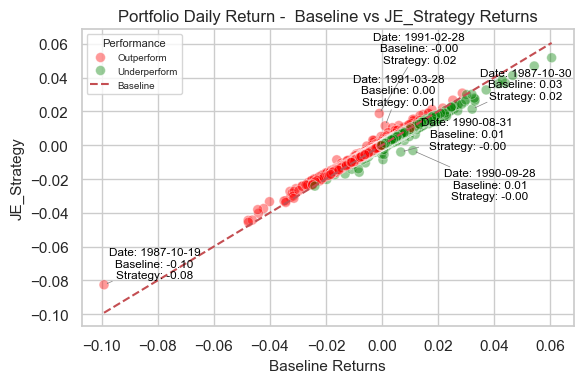

In [34]:
baseline_portfolio_daily_returns_semi_annual = semi_annual_portfolio_daily_returns_dict['Baseline']
strategy_portfolio_daily_returns_dict_semi_annual = {k: v for k, v in semi_annual_portfolio_daily_returns_dict.items() if k != 'Baseline'}
signficiant_points_df = plot_baseline_vs_strategy(baseline_portfolio_daily_returns_semi_annual, strategy_portfolio_daily_returns_dict_semi_annual, title_prefix='Portfolio Daily Return - ', dot_size=50)

In [35]:
signficiant_points_df['Strategy Performance'] = signficiant_points_df.apply(
    lambda row: 'Outperform' if row['Strategy Return'] > row['Baseline Return'] else 'Underperform', axis=1
)
# Reorder columns to make 'Strategy' the last column
columns = ['Date', 'Baseline Return', 'Strategy Return', 'Strategy Performance', 'Strategy']
signficiant_points_df = signficiant_points_df[columns]

signficiant_points_df

,Date,Baseline Return,Strategy Return,Strategy Performance,Strategy
0,1987-10-19,-0.099235,-0.073270,Outperform,JS_Strategy
1,1987-10-21,0.044119,0.032575,Underperform,JS_Strategy
2,1987-10-26,-0.040141,-0.029638,Outperform,JS_Strategy
3,1987-10-30,0.032253,0.021756,Underperform,JS_Strategy
4,1990-08-31,0.006740,-0.004691,Underperform,JS_Strategy
5,1990-09-28,0.011077,-0.003889,Underperform,JS_Strategy
6,1991-02-28,-0.000934,0.019060,Outperform,JS_Strategy
7,1991-03-28,0.001171,0.011740,Outperform,JS_Strategy
8,2008-10-13,0.060621,0.046279,Underperform,JS_Strategy
9,2008-10-28,0.054417,0.041560,Underperform,JS_Strategy


In [36]:
# Summary statistics
summary_stats = signficiant_points_df.describe()
print(summary_stats)

       Baseline Return  Strategy Return
count        23.000000        23.000000
mean          0.002622         0.002523
std           0.040693         0.031938
min          -0.099235        -0.082660
25%          -0.000934        -0.003953
50%           0.006740         0.011500
75%           0.032253         0.021230
max           0.060621         0.046279


In [37]:
# Count of Outperformance vs Underperformance
performance_counts = signficiant_points_df.groupby(['Strategy', 'Strategy Performance']).size().unstack(fill_value=0)
print(performance_counts)

Strategy Performance  Outperform  Underperform
Strategy                                      
JB_Strategy                    2             3
JE_Strategy                    3             3
JS_Strategy                    5             7


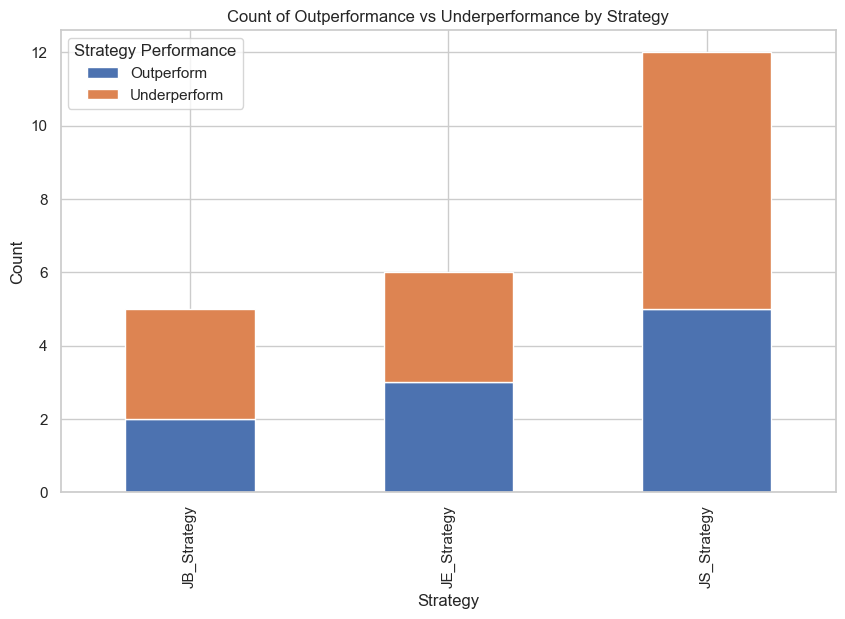

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for performance counts
performance_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Count of Outperformance vs Underperformance by Strategy')
plt.xlabel('Strategy')
plt.ylabel('Count')
plt.show()